In [1]:
import sympy as sp

sp.init_printing()

# Working with vectors

Much of the work that gets done in the upper-level undergraduate physics curriculum involves vectors, either explicitly or implicitly. There are two obvious ways to approach the problem of storing and manipulating vector functions in `sympy`:
1. Vectors-as-matrices
2. The `sympy.physics.vector` module.
3. The `sympy.vector` module (which is **not** the same as the previous one).

The first of these has a somewhat easier learning curve but isn't as full featured as the others. That said, I have yet to find any task that is prohibitively difficult using any of the methods, so I would say you should pick one and get to know it well enough that you're comfortable using it. I'll discuss all three here.

---
## Vectors-as-matrices

In this approach, you simply build $1\times n$ or $n\times 1$ matrices, and treat them as row or column vectors, respectively. There are no unit vectors as such; everything is positional within the matrices you create.

In [2]:
a = sp.symbols("a_x:z")
b = sp.symbols("b_x:z")

# a is a list with three elements
avec = sp.Matrix([a])
avec

The transpose of a matrix (in this case, converting a row vector to a column vector, or *vice-versa*) can be accessed by appending `.T`.

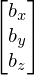

In [3]:
# b is also a list; I've written it out explicitly here.
bvec = sp.Matrix([[b[0], b[1], b[2]]]).T
bvec

Dot and cross products are provided by the `dot()` and `cross()` methods.

In [4]:
avec.dot(bvec)

In [5]:
avec.cross(bvec)

The standard multiplication operator `*` does matrix multiplication, which is likely not what you want in this context...

In [6]:
avec * bvec

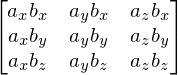

In [7]:
bvec * avec

... but it can be used for linear transformations.

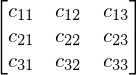

In [8]:
c = sp.symbols('c_1:4_1:4')
C = sp.Matrix([c[0:3], c[3:6], c[6:9]])
C

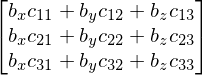

In [9]:
C * bvec

You can quite easily build matrix equations which `sympy.solve` can solve.

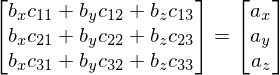

In [10]:
matrixeq = sp.Eq(C*bvec, avec.T, evaluate=False)
matrixeq

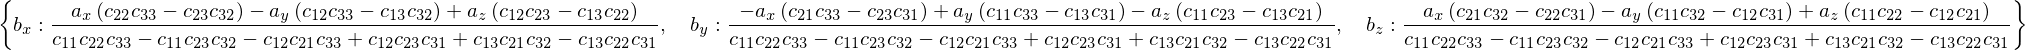

In [11]:
sp.solve(matrixeq, b)

### Vector calculus

Gradients, divergences, and curls are not fundamental operations on matrices, so they are not automatically included in this approach; you have to code your own. Furthermore, since you don't have a `ReferenceFrame` or `CoordSys3D` to contain the coordinates and unit vectors, you have to be a little careful about how you define things. Here are some examples:

In [12]:
def gradient(phi):
    """Take the gradient of a scalar function phi.
    
    We're assuming that phi is a function of sympy symbols x, y, z.
    
    Returns:
    --------
    A row vector.
    """
    
    x,y,z = sp.symbols('x y z')
    xterm = sp.diff(phi, x)
    yterm = sp.diff(phi, y)
    zterm = sp.diff(phi, z)
    
    return sp.Matrix([[xterm, yterm, zterm]])

def divergence(vec):
    """Take the divergence of vec."""
    
    x,y,z = sp.symbols('x,y,z')
    xterm = sp.diff(vec[0], x)
    yterm = sp.diff(vec[1], y)
    zterm = sp.diff(vec[2], z)
    
    return xterm + yterm + zterm

def curl(vec):
    """Take the curl of vec."""
    
    x,y,z = sp.symbols('x,y,z')
    xterm = sp.diff(vec[2], y) - sp.diff(vec[1], z)
    yterm = sp.diff(vec[0], z) - sp.diff(vec[2], x)
    zterm = sp.diff(vec[1], x) - sp.diff(vec[0], y)
    
    return sp.Matrix([[xterm, yterm, zterm]])
    

## The `physics.vector` module

Vectors in the `physics.vector` module begin with a reference frame. This is a cartesian coordinate system which may have a location, orientation, velocity, and/or angular velocity with respect to any other reference frame.

In [13]:
from sympy.physics import vector as physicsvector

N = physicsvector.ReferenceFrame('N')

Since the reference frame includes a cartesian coordinate system, it has unit vectors in its $x$, $y$, and $z$ directions.

In [14]:
N.y

Each reference frame also has coordinate scalars which correspond to the distance from the origin in the local $x$, $y$, and $z$ directions.

In [15]:
N[1]

It's very important to keep these separate in your head. `N.y` is the unit vector in the local $y$ direction, and `N[1]` is the local $y$ coordinate. When I'm working with a single reference frame, I find it convenient to streamline the notation a little bit:

In [16]:
S = physicsvector.ReferenceFrame('S', latexs=[r"\hat{\mathbf{x}}", r"\hat{\mathbf{y}}", r"\hat{\mathbf{z}}"],
                          variables=['x', 'y', 'z'])

In [17]:
S[1]*S.y

Now that we have a reference frame with unit vectors, we can build vectors algebraically.

In [18]:
avec = a[0]*S.x + a[1]*S.y + a[2]*S.z
bvec = b[0]*S.x + b[1]*S.y + b[2]*S.z
avec

Dot and cross products work the same way as they do in the vectors-as-matrices approach.

In [19]:
avec.dot(bvec)

There seems to be a bug in the implementation of the `physics.vector` module that makes printing under certain conditions raise an `AttributeError`.  If you're working in a notebook (as we are) it's safe to ignore this, and the output ends up looking ok, but it is annoying.

In [20]:
avec.cross(bvec)

AttributeError: 'tuple' object has no attribute 'right'

Matrix multiplication doesn't work in a straightforward way, however, because the Matrix module thinks that `physics.vector` objects are scalars, and treats them accordingly.

AttributeError: 'Fake' object has no attribute 'width'

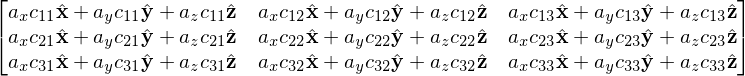

In [21]:
C * avec

It's possible to do linear transformations using this approach, but you have to do it by manipulating `ReferenceFrame`s. For some kinds of transformations (rotations come to mind) this makes a lot of sense, because it's very physically motivated. For others (like changing to an eigenvector basis for some operator) it's less obvious how to put it together.

### Vector calculus

The good news is, we get vector differential operators for free. Well, almost free. We have to make sure that our functions explicitly depend on the unit scalars in our coordinate system.

In [22]:
a_1 = sp.function.Function('a_1')(S[0], S[1], S[2])
a_2 = sp.function.Function('a_2')(S[0], S[1], S[2])
a_3 = sp.function.Function('a_3')(S[0], S[1], S[2])

avec = a_1*S.x + a_2*S.y + a_3*S.z
avec

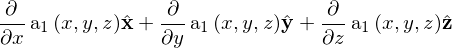

In [23]:
physicsvector.gradient(a_1, S)

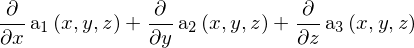

In [24]:
physicsvector.divergence(avec, S)

AttributeError: 'tuple' object has no attribute 'right'

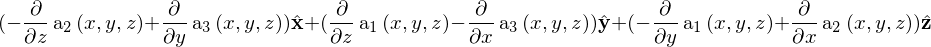

In [25]:
physicsvector.curl(avec, S)

---

## The `sympy.vector` module

This approach is very similar to the previous one, but with a couple of wrinkles. First, instead of a `ReferenceFrame`, you now need a coordinate system (a `CoordSys3D` object). In the current (1.1.1) version of `sympy`, only cartesian coordinates are officially supported, but other coordinate systems are available in the development version. As you'll see at the end of this section, we can cheat a bit to make use of spherical and cartesian coordinates.

In [26]:
import sympy.vector as vector

In [27]:
C = vector.CoordSys3D('C')

In [28]:
C.x

If you rerun these cells, you will see that the developers made three bad choices in putting together the pretty printing here. First of all, scalars ought to be italicized instead of bold, and second, there isn't a convenient way to get rid of the subscripts. The result is that vectors using this approach are cluttered and hard to read. Lastly, they went with i, j, and k for the unit vectors. That's a matter of personal preference, I guess, but I don't care for it. (Furthermore, if you're going to use hats on i or j, you should use the dotless versions.)

I've patched my own copy of the code, so it looks nicer (because I'm super picky).

In [29]:
C.x*C.i + C.y*C.j + C.z*C.k

You can get around the subscript problem by giving the coordinate system an empty string for a name, and you can rename the unit vectors (though it supplies the hats and bold face for you). The coordinate scalars are still in bold face, which bothers me more than it should.

In [30]:
R = vector.CoordSys3D('', vector_names=['x', 'y', 'z'])
R.x*R.i + R.y*R.j + R.z*R.k

In [31]:
avec = a[0]*R.i + a[1]*R.j + a[2]*R.k
bvec = b[0]*R.i + b[1]*R.j + b[2]*R.k

In [32]:
avec.dot(bvec)

In [33]:
avec.cross(bvec)

The pretty printer used in the `sympy.vector` module fortunately doesn't have the same bug as the `physics.vector` module; that may be enough reason to choose this one. Otherwise, it's about the same. Linear transformations happen by working with coordinate systems, and we get vector differential operators for free. Here, however, the coordinate scalars are obtained by introspection, and the coordinate system isn't a necessary argument.

In [34]:
phi = R.x*R.y*R.z
vector.gradient(phi)

In [35]:
vector.divergence(C.x*C.i + C.y*C.j + C.z*C.k)

In [36]:
vector.curl(C.x*C.y*C.k)

We get cylindrical and spherical coordinate systems, too, though you have to be a bit sneaky to make use of them. Actually, the machinery is there to work with any orthogonal curvilinear coordinate system, but spherical and cylindrical are especially easy. The key is to use the private method `vector.CoordSys3D._connect_to_standard_cartesian` with an argument of either `spherical` or `cylindrical`.

In common python practice, methods which start with an underscore are *private*, which means that they shouldn't be used by anyone externally. We're going to break that rule here because there isn't (yet) a public way to access this method, and it does what we need it to do.

For example, we can make a spherical coordinate system:

In [37]:
S = vector.CoordSys3D('', vector_names=['r', "\\theta", r"\phi"],
                     variable_names=['r', "\\theta", r"\phi"])

S._connect_to_standard_cartesian('spherical')

For convenience, I like to create some python variables with more intuitive names.

In [38]:
r = S.x
theta = S.y
phi = S.z
rhat = S.i
thetahat = S.j
phihat = S.k

Let's test it by taking the divergence and curl of a vector function.

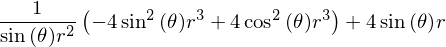

In [39]:
v = r**2*sp.sin(theta)*rhat + 4*r**2*sp.cos(theta)*thetahat + r**2*sp.tan(theta)*phihat

vector.divergence(v)

Messy. Can we tidy it up?

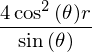

In [40]:
sp.simplify(vector.divergence(v))

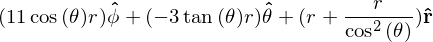

In [41]:
sp.simplify(vector.curl(v))

Beautiful. This is officially my preferred method of working with vectors in `sympy`. Note that it is new as of version 1.1 or 1.1.1 (not really sure which; I'm using 1.1.1 which is current as of this writing). If you have an earlier version, you'll have to use one of the other methods.